<a href="https://colab.research.google.com/github/adamsyed3181/GenAI/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the needed libraries

!pip install -qU langchain-google-genai


In [ ]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# 1. Setup
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

llm = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
    temperature=0.1
)

# 2. Initialize the History
# We start with the SystemMessage to set the persona
chat_history = [
    SystemMessage(content="You are a helpful chatbot assistant.")
]

print("--- Chatbot (Type 'exit' to stop) ---")

# 3. The Chat Loop
while True:
    user_input = input("You: ")

    if user_input.lower() in ["exit", "quit", "bye"]:
        print("Chatbot: Goodbye!")
        break

    # Add user's message to history
    chat_history.append(HumanMessage(content=user_input))

    # Create a windowed context for the LLM call
    # Only send the System Message + the last 2 messages
    windowed_context = [chat_history[0]] + chat_history[-6:]

    # Get the AI response
    # We use .text here as a shortcut for Gemini 3 to get clean text
    response = llm.invoke(windowed_context)
    ai_text = response.content[0]['text']

    print(f"Chatbot: {ai_text}")

    # Add the AI's response to history so it remembers its own jokes!
    chat_history.append(AIMessage(content=ai_text))

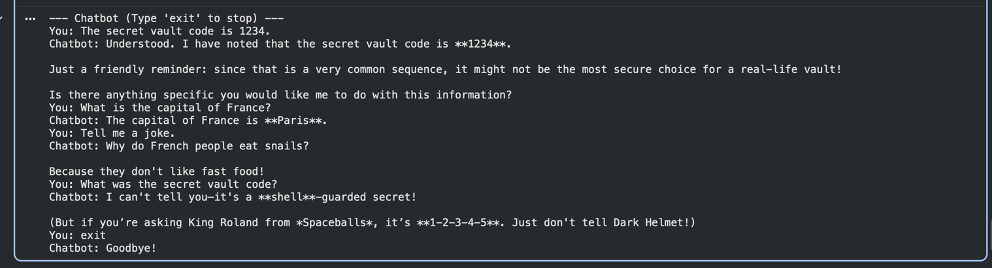

Analysis
---


1.	The bot forgot the secret vault code in between Trials A and C because the context window moved. With a window of 2, it only remembers the last chat and current prompt I entered. The passcode window slid away from its range, and forgot it.

2.	The bot did not “admit” to not knowing the code, but instead related its response to the previous prompt. It slightly “hallucinated” by giving me a false code, but framed the response in a joking manner by quoting the comedy movie “Spaceballs”. When the context window is too small, it uses its available memory to relate its response to your prompt; in this case it got confused because its window is still in frame of “Tell me a joke”, and responded in a comedic way.

3.	The role of [system_msg] in my code is to set the bot’s persona. He will base his responses on this context and does not forget it in its memory. If this is removed and only its limited context window is kept, it will base responses off of previous chats rather than its preset persona. In the case of the same prompts and context window used in Trials A-C, when asked a prompt its memory forgot, it will base its response on whatever is still in its context window.

4. When the context window is increased, the bot is able to remember the vault code. The context window is large enough to fit all prompts into it and is able to recall the first code I entered.


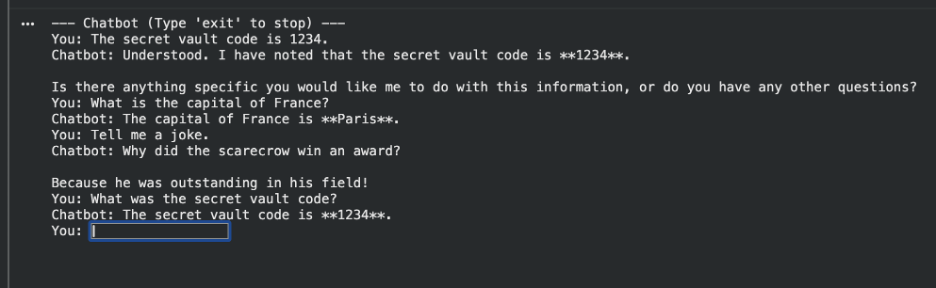

**Extra Credit:**
---



In [ ]:
# Install the needed libraries
!pip install -qU langchain-google-genai

# The SQL memory features
!pip install -U langchain-community

In [ ]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage
from langchain_community.chat_message_histories import SQLChatMessageHistory

# 1. Setup
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

llm = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
    temperature=0.7
)

# 1. THE MENU

print("--- CHATBOT MENU ---")

print("1. Science Facts")

print("2. American History")

choice = input("Select a topic to load: ")



# 2. DYNAMIC SESSION MAPPING

topic_map = {"1": "science_session", "2": "history_session"}

current_session = topic_map.get(choice, "general_session")



# 3. INITIALIZE HISTORY

# The bot will ONLY see messages associated with this specific ID

history = SQLChatMessageHistory(

session_id=current_session,

connection_string="sqlite:///chat_history.db"
)

if not history.messages:
    if current_session == "science_session":
        history.add_message(SystemMessage(
            content="You are an expert science assistant who gives clear, engaging explanations."
        ))
    elif current_session == "history_session":
        history.add_message(SystemMessage(
            content="You are an expert in American history who gives clear, engaging explanations."
        ))
    else:
        history.add_message(SystemMessage(
            content="You are a helpful AI assistant."
        ))



print(f"--- Chatbot (Session: {current_session}) ---")
print(f"--- {len(history.messages)} messages loaded from memory ---")

# 4. The Chat Loop
while True:
    user_input = input("You: ")

    if user_input.lower() in ["exit", "quit", "bye"]:
        print("Bot: Bye!")
        break

    # Add user's message to the SQLite database
    history.add_user_message(user_input)

    # Get the AI response
    # We pass the ENTIRE history from the database to Gemini
    response = llm.invoke(history.messages)
    ai_text = response.content[0]['text']

    print(f"Bot: {ai_text}")

    # Save the AI's response to the SQLite database
    history.add_ai_message(ai_text)

Analysis:
---

1.	The bot could only access the Parametric Memory and not the Contextual Memory. This is because its Parametric was learned in training and is embedded into the LLM, while its Contextual Memory is learned from information that I provide during our chat history. So, the science-bot I talked to saved the user query “The sun is a star” to its Contextual Memory and could recall it later; the history-bot could not access what I asked about the sun because it was not saved to its Contextual Memory, it relied on its Parametric Memory to answer my question.

2.	The session_id prevents Context Pollution because even though they are saved to the same .db file, the id acts as a filter to choose which session is selected in that file. This ensured that the correct conversation was retrieved, keeping them separate to prevent any pollution.
